# 第一题：使用sklearn的多层感知机

实验内容：  
1. 使用sklearn.neural_network.MLPClassifier完成手写数字分类任务
2. 绘制学习率为3，1，0.1，0.01训练集损失函数的变化曲线

## 1. 读取数据集

我们使用的是sklearn里面自带的手写数字数据集

In [1]:
from sklearn.datasets import load_digits

数据集有这几个键

In [2]:
load_digits().keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

打印数据集的描述

In [3]:
print(load_digits()['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

一共1797个样本，每个样本都是$8 \times 8$的矩阵，因为是灰度的图像，所以只有一个通道  
images对应的是原始的图像，data对应的是 $8 \times 8$ reshape成 $1 \times 64$ 的数据，target是标记，表示这张图片里面的数字是几

打印第一个样本

In [4]:
load_digits()['images'][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

对数据集的前十张图片可视化

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

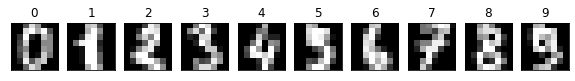

In [6]:
_, figs = plt.subplots(1, 10, figsize=(10, 4))
for f, img, lbl in zip(figs, load_digits()['images'][:10], load_digits()['target'][:10]):
    f.imshow(img, cmap = 'gray')
    f.set_title(lbl)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

## 2. 划分数据集

In [7]:
from sklearn.model_selection import train_test_split

取40%为测试集，60%为训练集

In [8]:
trainX, testX, trainY, testY = train_test_split(load_digits()['data'], load_digits()['target'], test_size = 0.4, random_state = 32)

In [9]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((1078, 64), (1078,), (719, 64), (719,))

## 3. 数据预处理

In [10]:
from sklearn.preprocessing import StandardScaler

神经网络的训练方法一般是基于梯度的优化算法，如梯度下降，为了让这类算法能更好的优化神经网络，我们往往需要对数据集进行归一化，这里我们选择对数据进行标准化

$$X' = \frac{X - \bar{X}}{\mathrm{std}(X)}$$

其中，$\bar{X}$是均值，$\mathrm{std}$是标准差。减去均值可以让数据以0为中心，除以标准差可以让数据缩放到一个较小的范围内。这样可以使得梯度的下降方向更多样，同时缩小梯度的数量级，让学习变得稳定。  
首先需要对训练集进行标准化，针对每个特征求出其均值和标准差，然后用训练集的每个样本减去均值除以标准差，就得到了新的训练集。然后用测试集的每个样本，减去训练集的均值，除以训练集的标准差，完成对测试集的标准化。

In [11]:
# 初始化一个标准化器的实例
standard = StandardScaler()

# 对训练集进行标准化，它会计算训练集的均值和标准差保存起来
trainX = standard.fit_transform(trainX)

# 使用标准化器在训练集上的均值和标准差，对测试集进行归一化
testX = standard.transform(testX)

可以打印看一下数据集归一化后的效果，均值很接近0

In [12]:
trainX.mean(), testX.mean()

(1.4418480839287748e-18, -0.005673919242693978)

## 4. 引入模型

In [13]:
from sklearn.neural_network import MLPClassifier

我们使用sklearn中自带的MLPClassifier，MLP是多层感知机(multi-layer perceptron)的简称。  
在训练的时候需要指定参数，这里我们需要设置的几个参数有：
1. solver: 'sgd'，这个参数的含义是，使用随机梯度下降作为优化算法
2. learning_rate: 'constant'，学习率固定，不衰减
3. momentum: 0，动量设置为0，这是随机梯度下降需要的一个参数，我们设置为0即可
4. max_iter: 设定最大迭代轮数，如果超过这个轮数还没有收敛，就停止训练，并抛出一个warning
5. learning_rate_init，这个参数需要我们进行调整，这是学习率

这个模型会判断，如果连续两轮损失值都没有减少了，就停止训练。

In [14]:
model = MLPClassifier(solver = 'sgd', learning_rate = 'constant', momentum = 0, learning_rate_init = 0.1, max_iter = 500)
model.fit(trainX, trainY)
prediction = model.predict(testX)

# 5. 预测与评估

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(prediction, testY)

0.9833101529902643

精度达到了98%

## 6. 绘制训练集损失函数值的变化曲线

我们可以通过model.loss_curve_获取模型在训练过程中，损失函数损失值的变化曲线

Text(0, 0.5, 'loss')

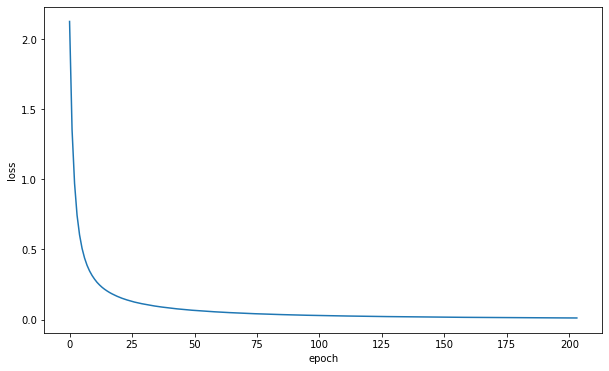

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(model.loss_curve_)
plt.xlabel('epoch')
plt.ylabel('loss')

可以看到随着迭代轮数的增加，loss降低地越来越缓慢

## 课后部分：请你在一张图内，绘制出学习率为3，学习率为1，学习率为0.1，学习率为0.01，四个模型的损失函数变化曲线，最大迭代轮数为250轮。并结合参数学习率对图形进行分析

提示：分别训练4个模型，然后在一张图中分别绘制4个模型的loss_curve_即可。

学习率为3精度： 0.9847009735744089
学习率为1精度： 0.9847009735744089
学习率为0.1精度： 0.9777468706536857
学习率为0.01精度： 0.96105702364395


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 19981 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 21516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 19979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-

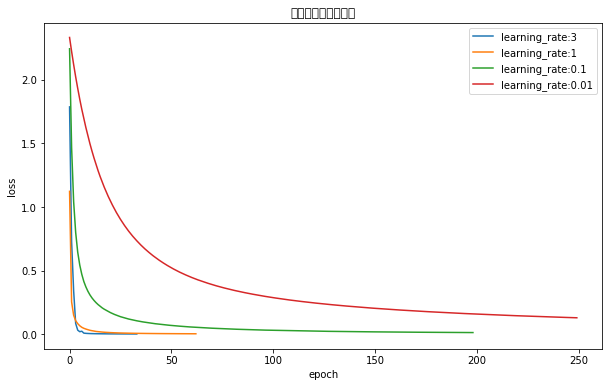

In [27]:
model = MLPClassifier(solver = 'sgd', learning_rate = 'constant', momentum = 0, learning_rate_init = 3, max_iter = 250)
model.fit(trainX, trainY)
prediction = model.predict(testX)
print("学习率为3精度：",accuracy_score(prediction, testY))

modelx = MLPClassifier(solver = 'sgd', learning_rate = 'constant', momentum = 0, learning_rate_init = 1, max_iter = 250)
modelx.fit(trainX, trainY)
predictionx = modelx.predict(testX)
print("学习率为1精度：",accuracy_score(predictionx, testY))

modely = MLPClassifier(solver = 'sgd', learning_rate = 'constant', momentum = 0, learning_rate_init = 0.1, max_iter = 250)
modely.fit(trainX, trainY)
predictiony = modely.predict(testX)
print("学习率为0.1精度：",accuracy_score(predictiony, testY))

modelz = MLPClassifier(solver = 'sgd', learning_rate = 'constant', momentum = 0, learning_rate_init = 0.01, max_iter = 250)
modelz.fit(trainX, trainY)
predictionz = modelz.predict(testX)
print("学习率为0.01精度：",accuracy_score(predictionz, testY))


plt.figure(figsize = (10, 6))
plt.plot(model.loss_curve_,'-',label = 'learning_rate:3')
plt.plot(modelx.loss_curve_,'-',label = 'learning_rate:1')
plt.plot(modely.loss_curve_,'-',label = 'learning_rate:0.1')
plt.plot(modelz.loss_curve_,'-',label = 'learning_rate:0.01')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("不同学习率下的表现")
plt.legend()

由上图可以看出，随着学习率的增大，不同阶段的损失函数不同，学习率为3时，损失函数随阶段的变化，减小最快。
在设置最大迭代数为250轮的时候，学习率为0.01的没有收敛